1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pydotplus

from pandas import Series, DataFrame

from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.externals.six import StringIO

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image

In [83]:
df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv")
df =df.drop('Unnamed: 0',1)
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [84]:
df['default'] = df['default'].replace("Yes",1).replace("No",0)
df['student'] = df['student'].replace("Yes",1).replace("No",0)
df.head(10)

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879
5,0,1,919.588530,7491.558572
6,0,0,825.513331,24905.226578
7,0,1,808.667504,17600.451344
8,0,0,1161.057854,37468.529288
9,0,0,0.000000,29275.268293


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

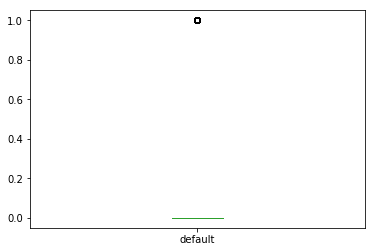

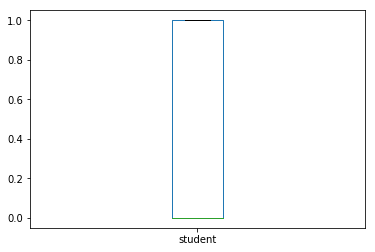

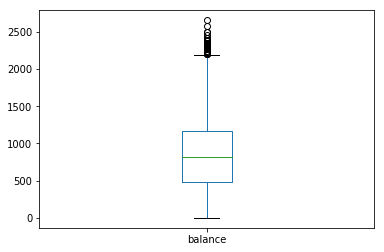

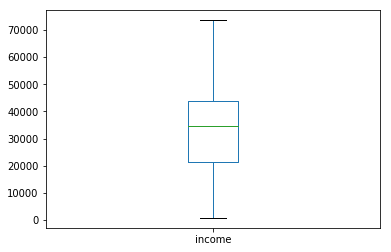

(<matplotlib.axes._subplots.AxesSubplot at 0x1a179139b0>, None)

In [85]:
df['default'].plot.box(), plt.show()
df['student'].plot.box(), plt.show()
df['balance'].plot.box(), plt.show()
df['income'].plot.box(), plt.show()

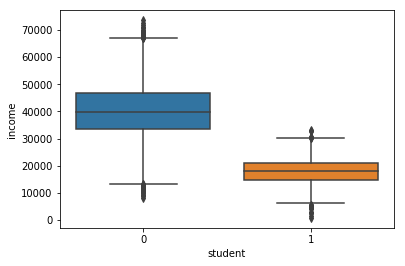

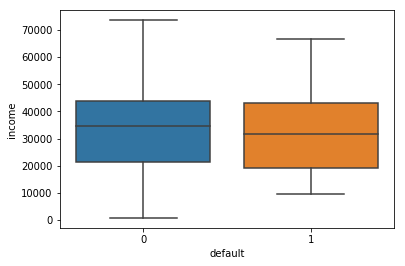

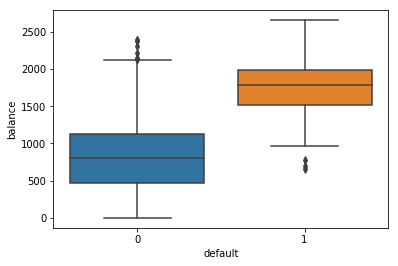

In [86]:
stu_inc = sns.boxplot(x='student',y='income',data=df)
plt.show()
defau_inc = sns.boxplot(x='default',y='income',data=df)
plt.show()
defua_bal = sns.boxplot(x='default',y='balance',data=df)
plt.show()


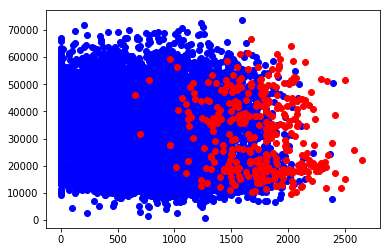

In [87]:
plt.scatter(df.balance[df['default']==0], df.income[df['default']==0],c='blue')
plt.scatter(df.balance[df['default']==1], df.income[df['default']==1],c='red')
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

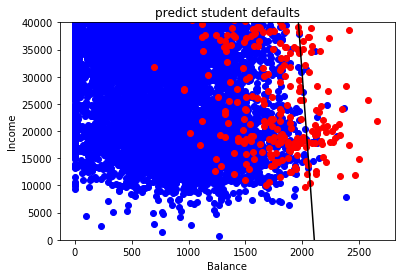

In [100]:
#data selection
student_df=df[df['student']==1] 
student_df.head()
X = student_df[['balance','income']]
y = student_df['default']

# Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 200)

logreg = LogisticRegression(penalty='l1')
clf = logreg.fit(X_train,y_train)

coef = clf.coef_
a = coef[0]
b = clf.intercept_

x = np.arange(0, 2600, 1)
y = (b + a[0] * x) / -a[1]

plt.scatter(df.balance[df['default']==0], df.income[df['default']==0],c='blue')
plt.scatter(df.balance[df['default']==1], df.income[df['default']==1],c='red')
plt.plot(x, y, c = 'black')
plt.ylim(0, 40000)
plt.title('predict student defaults')
plt.xlabel('Balance')
plt.ylabel('Income')
plt.show()


AUC ROC = 0.945438


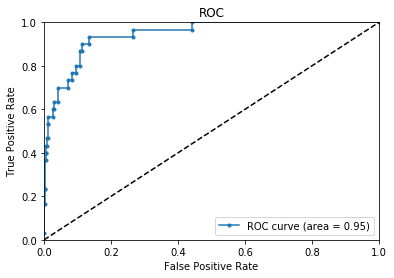

In [101]:
# Computation of AUC ROC
probas_ = logreg.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC ROC = %f" % roc_auc)

# Plot AUC ROC
plt.clf()
plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

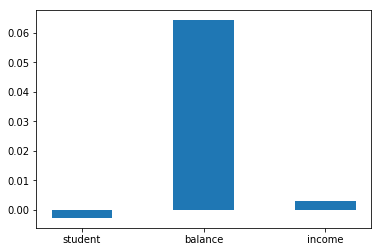

Coefficients:  [-0.00280049  0.06434194  0.00306679]


In [102]:
X = df[['student','balance','income']]
y = df['default']
scaler = StandardScaler() 
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

alpha = np.logspace(-5, -1, 100)
score = []

for a in alpha:
    regr = Ridge(alpha = a)
    regr.fit(X_train, y_train)
    score.append(regr.score(X_test, y_test))
    
idx = np.array(score).argmax()
regr = Ridge(alpha = alpha[idx])
regr.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), regr.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('student', 'balance','income'))
rects = ax.patches
plt.show()
print('Coefficients: ', regr.coef_)

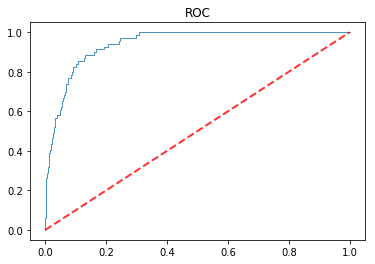

AUC ROC = 0.943545
performance did not improve with the added variable


In [103]:
def get_auc(X,y,fit):
    probas_ = fit.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

LR = LogisticRegression(penalty='l1', C= alpha[idx])
lreg = LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

fpr, tpr, thresholds, roc_auc = get_auc(X_test,y_test,lreg)
plt.plot(fpr, tpr, lw=1, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.title('ROC')
plt.show()
print("AUC ROC = %f" % roc_auc)

print('performance did not improve with the added variable')

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

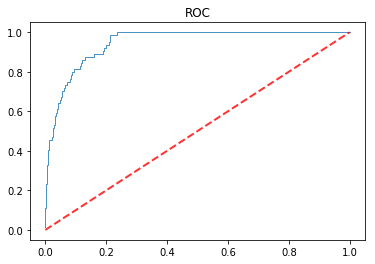

AUC ROC = 0.947322


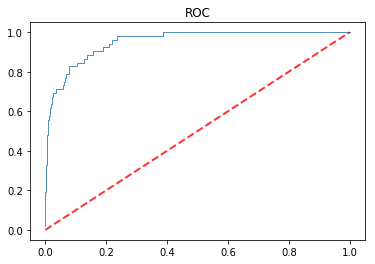

AUC ROC = 0.953088


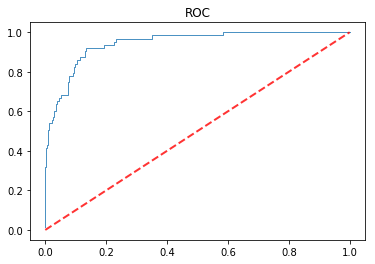

AUC ROC = 0.945563


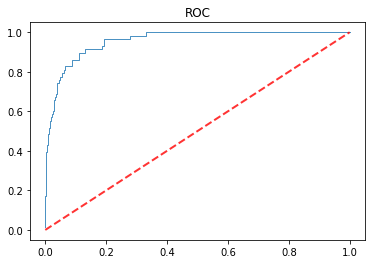

AUC ROC = 0.958006


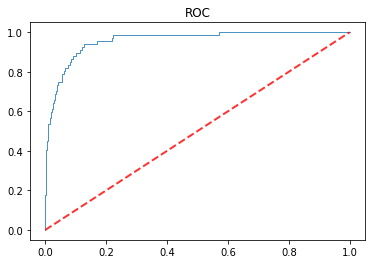

AUC ROC = 0.959061


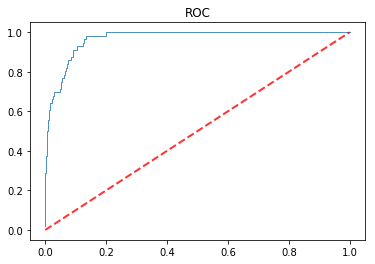

AUC ROC = 0.969053


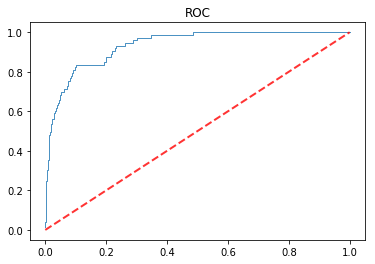

AUC ROC = 0.935580


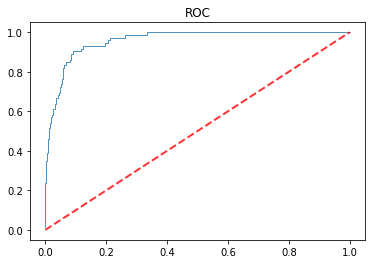

AUC ROC = 0.959781


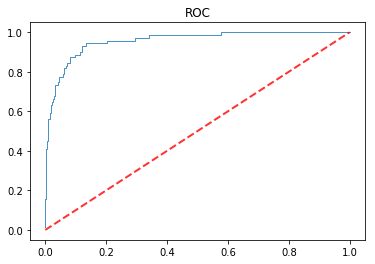

AUC ROC = 0.957206


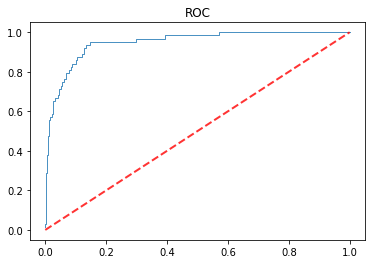

AUC ROC = 0.950078
According the scores we got, it seems like the model is robust


In [104]:
rand=np.random.randint(10000, size=(10))

for state in rand:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)
    LR = LogisticRegression(penalty='l1', C= alpha[idx])
    lreg = LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    fpr,tpr,thresholds, roc_auc = get_auc(X_test,y_test,lreg)
    plt.plot(fpr, tpr, lw=1, alpha=0.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.title('ROC')
    plt.show()
    print("AUC ROC = %f" % roc_auc)
    

print('According the scores we got, it seems like the model is robust')

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

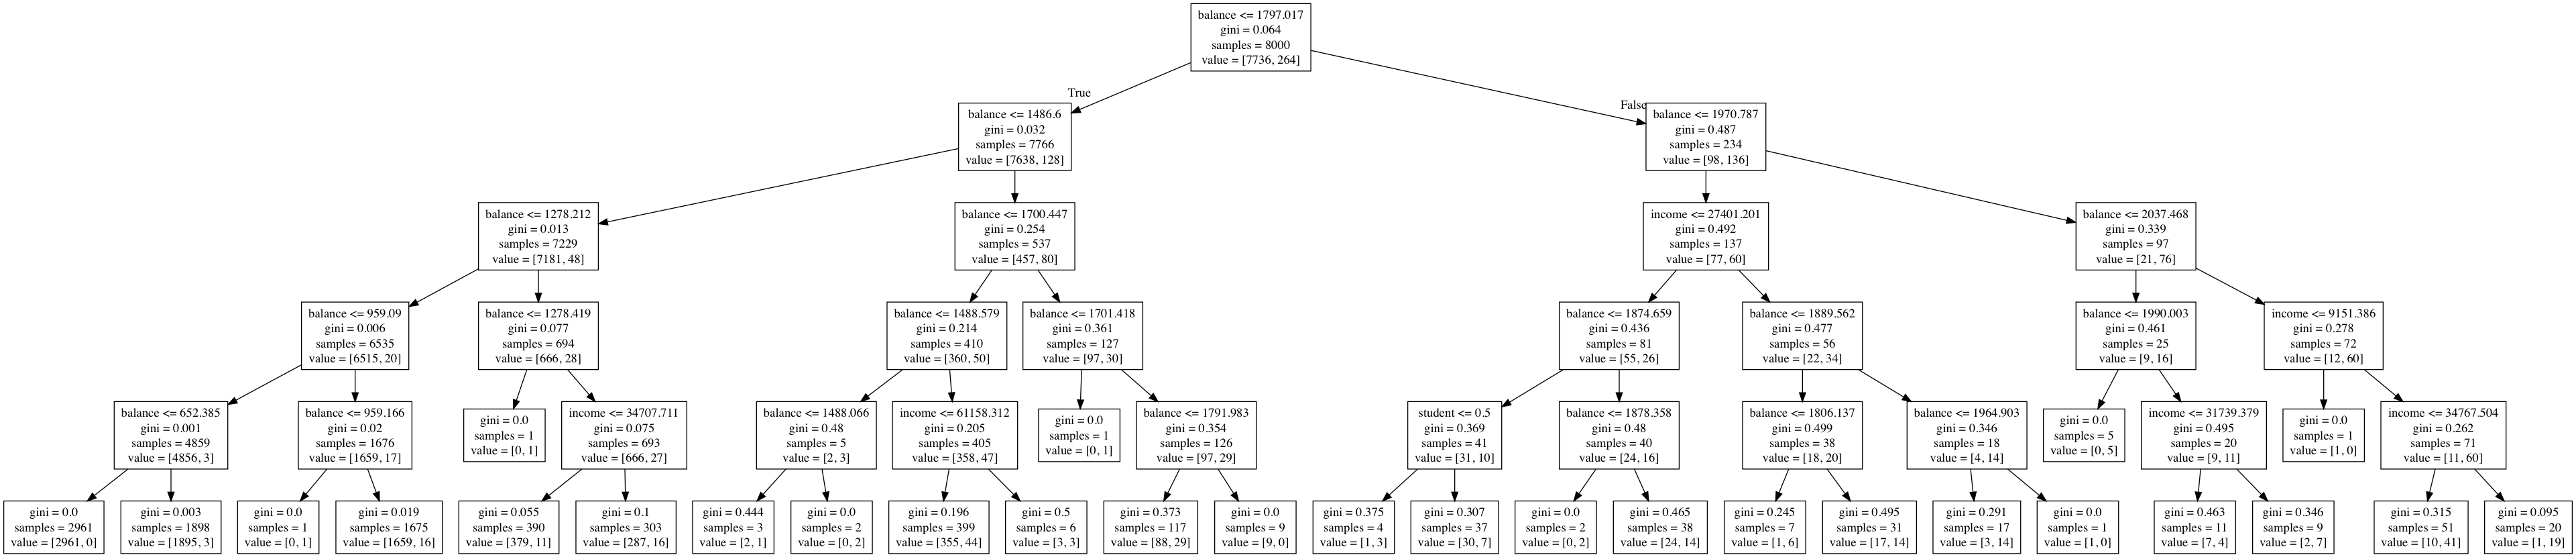

In [78]:
X = df[['student','balance','income']]
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train,y_train)

dot_data = StringIO()  
export_graphviz(clf, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

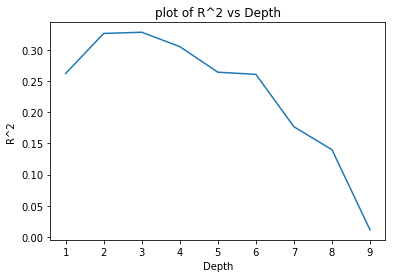

According to the figure shown below, the best decision tree depth is 3.00 


In [107]:
training_errors=[]
test_e=[]
scores=[]
depths = range(1,10)
for n in depths:
    tree = DecisionTreeRegressor(max_depth=n)
    tree.fit(X_train, y_train)
    training_errors.append(tree.score(X_train,y_train))
    scores.append(tree.score(X_test,y_test))
plt.ylabel('R^2 ')
plt.xlabel('Depth')
plt.plot(depths,scores)
plt.title('plot of R^2 vs Depth')
test_e=scores
n_opt=depths[np.argmax(scores)]
plt.show()
print('According to the figure shown below, the best decision tree depth is %0.2f '% (n_opt))

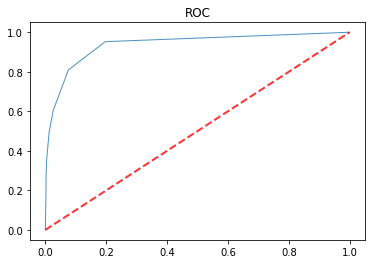

AUC ROC = 0.937504


In [108]:
odt = DecisionTreeClassifier(max_depth=n_opt)
odt.fit(X_train, y_train)
fpr, tpr, thresholds, roc_auc = get_auc(X_test,y_test,odt)
plt.plot(fpr, tpr, lw=1, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.title('ROC')
plt.show()
print("AUC ROC = %f" % roc_auc)